<a href="https://colab.research.google.com/github/skrofman/Applied-Machine-Learning/blob/master/lab7_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import tree
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import datasets
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_breast_cancer

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [35]:
diabetes = datasets.load_diabetes()
columns = 'age gender bmi map tc ldl hdl tch ltg glu'.split()
df = pd.DataFrame(diabetes.data, columns=columns)
y = diabetes.target

In [36]:
# Implementation of stepwise regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.001, 
                       threshold_out = 0.001, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [37]:
X=df
result = stepwise_selection(X,y)

Add  bmi                            with p-value 3.46601e-42
Add  ltg                            with p-value 3.03968e-20
Add  map                            with p-value 3.74192e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [38]:
df=X
model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=310)
df=pd.get_dummies(df)
model.fit(df,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=310,
                       verbose=0, warm_start=False)

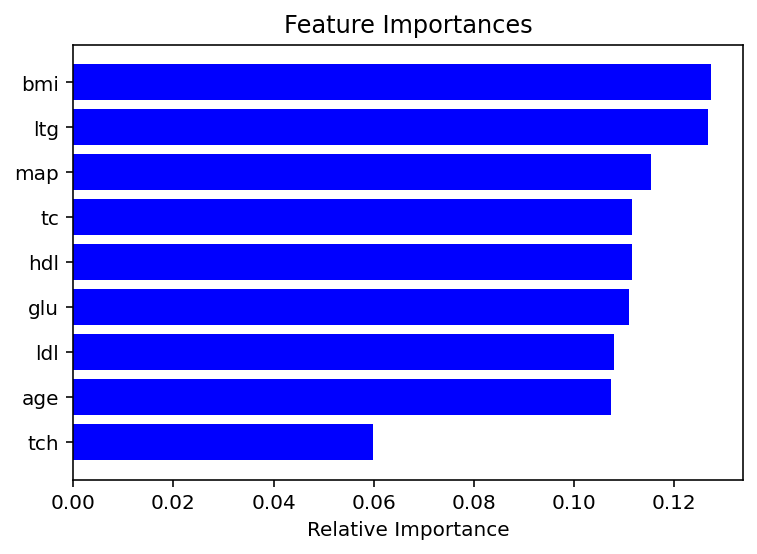

In [39]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scale = StandardScaler()

In [ ]:
Xs = scale.fit_transform(X)

In [ ]:
model = lm.ElasticNet(alpha=0.25,l1_ratio = 0.5)
model.fit(Xs,y)
model.coef_

array([ 0.0313514 , -9.33445083, 22.85217131, 14.04952967, -3.1059829 ,
       -3.48167818, -9.13535641,  5.23494772, 20.44145217,  4.20866431])

In [ ]:
v = -np.sort(-np.abs(model.coef_))
for i in range(X.shape[1]):
  print(X.columns[np.abs(model.coef_)==v[i]])

Index(['bmi'], dtype='object')
Index(['ltg'], dtype='object')
Index(['map'], dtype='object')
Index(['gender'], dtype='object')
Index(['hdl'], dtype='object')
Index(['tch'], dtype='object')
Index(['glu'], dtype='object')
Index(['ldl'], dtype='object')
Index(['tc'], dtype='object')
Index(['age'], dtype='object')


In [70]:
dat = load_breast_cancer()
df = pd.DataFrame(data=dat.data, columns=dat.feature_names)
y = dat.target

In [71]:
def validation(X,y,k,model):
  accuracy = []
  pipe = Pipeline([('scale',scale),('Classifier',model)])
  kf = KFold(n_splits=k,shuffle=True,random_state=1693)
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    y_train = y[idxtrain]
    X_test = X[idxtest,:]
    y_test = y[idxtest]
    pipe.fit(X_train,y_train)
    accuracy.append(accuracy_score(y_test,pipe.predict(X_test)))
  return np.mean(accuracy)

In [78]:
def validation(X,y,k,model):
  accuracy = []
  pipe = Pipeline([('Classifier',model)])
  kf = KFold(n_splits=k,shuffle=True,random_state=1693)
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    y_train = y[idxtrain]
    X_test = X[idxtest,:]
    y_test = y[idxtest]
    pipe.fit(X_train,y_train)
    accuracy.append(accuracy_score(y_test,pipe.predict(X_test)))
  return np.mean(accuracy)

In [79]:
model = tree.DecisionTreeClassifier(random_state=1693, max_depth=28, min_samples_leaf=4)
feats = ['mean radius', 'mean texture']
X = df[feats].values
validation(X,y,10,model)

0.8453634085213032

In [74]:
model = tree.DecisionTreeClassifier(random_state=1693, max_depth=23, min_samples_leaf=4)
feats = ['mean radius', 'mean texture']
X = df[feats].values
validation(X,y,10,model)

0.8453634085213032

In [75]:
model = tree.DecisionTreeClassifier(random_state=1693, max_depth=22, min_samples_leaf=9)
feats = ['mean radius', 'mean texture']
X = df[feats].values
validation(X,y,10,model)

0.8647243107769423

In [76]:
model = tree.DecisionTreeClassifier(random_state=1693, max_depth=5, min_samples_leaf=19)
feats = ['mean radius', 'mean texture']
X = df[feats].values
validation(X,y,10,model)

0.8892543859649124

In [77]:
model = tree.DecisionTreeClassifier(random_state=1693, max_depth=21, min_samples_leaf=3)
feats = ['mean radius', 'mean texture']
X = df[feats].values
validation(X,y,10,model)

0.8471804511278196

In [82]:
model = tree.DecisionTreeClassifier(random_state=12345, max_depth=5, min_samples_leaf=19)
feats = ['mean radius', 'mean texture']
X = df[feats].values
model.fit(X, y);
predicted_classes = model.predict(X)

In [83]:
spc = ['No Default','Default']
cm = confusion_matrix(y,predicted_classes)
pd.DataFrame(cm, columns=spc, index=spc)

,No Default,Default
No Default,190,22
Default,31,326


In [102]:
model = tree.DecisionTreeClassifier(random_state=1234, max_depth=10, min_samples_leaf=20)
#columns = 'meanradius meantexture meanperimeter meanarea meansmoothness meancompactness meanconcavity meanconcavepoints meansymmetry meanfractaldimension radiuserror textureerror perimetererror areaerror smoothnesserror compactnesserror concavityerror concavepointserror symmetryerror fractaldimensionerror worstradius worsttexture worstperimeter worstarea worstsmoothness worstcompactness worstconcavity worstconcavepoints worstsymmetry worstfractaldimension'.split()
df = pd.DataFrame(data=dat.data, columns=dat.feature_names)
X=df
Xs = scale.fit_transform(X)
y = dat.target
#list(df.columns)
#result = stepwise_selection(Xs,y)

In [105]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_dif = label_encoder.fit_transform(y)

In [106]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
principal_Components = pca.fit_transform(Xs)
#principal_df = pd.DataFrame(data = principal_Components)
#final_df = pd.concat(principal_df, y)
model.fit(principal_Components, y);
predicted_classes = model.predict(principal_Components)

In [107]:
spc = ['No Default','Default']
cm = confusion_matrix(y,predicted_classes)
pd.DataFrame(cm, columns=spc, index=spc)

,No Default,Default
No Default,205,7
Default,28,329
